In [11]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product


In [2]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [3]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [6]:
chroms = [str(x) for x in range(1, 23)] #+ ['X']

ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'


In [8]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]  not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 880
Counter({22: 880})
Families with LCL 0
Final families 795
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 518
Counter({22: 518})
Families with LCL 0
Final families 518


In [25]:
sibpair_to_mat_match = defaultdict(int)
sibpair_to_mat_mismatch = defaultdict(int)
sibpair_to_pat_match = defaultdict(int)
sibpair_to_pat_mismatch = defaultdict(int)
sibpair_to_dataset = dict()

def load_phase_data(phase_dir, family_sizes, families_to_include, dataset):
    for chrom in chroms:
        print(chrom, end=' ')

        # pull families
        family_to_individuals = dict()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f: 
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        family_to_individuals[family_key] = pieces[1:(1+j)]
                        
        for famkey, individuals in family_to_individuals.items():
            for c1, c2 in combinations(individuals[2:], 2):
                sibpair_to_dataset[(min(c1, c2), max(c1, c2))] = dataset

        # now read phase info
        for j in family_sizes:
            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        length = end_pos - start_pos + 1

                        has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                        children = family_to_individuals[family_key][2:]
                        if inheritance_state[-1] == 0:
                            for i, child in enumerate(children):
                                if inheritance_state[4+(2*i)] == 0:
                                    has_m1.append(child)
                                elif inheritance_state[4+(2*i)] == 1:
                                    has_m2.append(child)
                                if inheritance_state[5+(2*i)] == 0:
                                    has_p1.append(child)
                                elif inheritance_state[5+(2*i)] == 1:
                                    has_p2.append(child)
                                    
                        # matches
                        for c1, c2 in combinations(has_m1, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_m2, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p1, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p2, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                            
                        # mismatches
                        for c1, c2 in product(has_m1, has_m2):
                            sibpair_to_mat_mismatch[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in product(has_p1, has_p2):
                            sibpair_to_pat_mismatch[(min(c1, c2), max(c1, c2))] += length


load_phase_data(ihart_phase_dir, ihart_family_sizes, ok_ihart_families, 'iHART')
load_phase_data(ssc_phase_dir, ssc_family_sizes, ok_ssc_families, 'SSC')



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

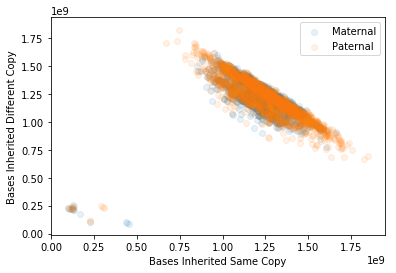

Removing 21 outliers


In [39]:
sibpairs = sorted(sibpair_to_dataset.keys())
mat_match = np.array([sibpair_to_mat_match[k] for k in sibpairs])
mat_mismatch = np.array([sibpair_to_mat_mismatch[k] for k in sibpairs])
pat_match = np.array([sibpair_to_pat_match[k] for k in sibpairs])
pat_mismatch = np.array([sibpair_to_pat_mismatch[k] for k in sibpairs])

plt.scatter(mat_match, mat_mismatch, alpha=0.1, label='Maternal')
plt.scatter(pat_match, pat_mismatch, alpha=0.1, label='Paternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

plt.legend()
plt.show()

outliers = (mat_match < 0.75*pow(10, 9)) | (mat_mismatch < 0.75*pow(10, 9)) | (pat_match < 0.75*pow(10, 9)) | (pat_mismatch < 0.75*pow(10, 9))
print('Removing %d outliers' % np.sum(outliers))

sibpairs = [sibpairs[i] for i in np.where(~outliers)[0]]
mat_match = mat_match[~outliers]
mat_mismatch = mat_mismatch[~outliers]
pat_match = pat_match[~outliers]
pat_mismatch = pat_mismatch[~outliers]


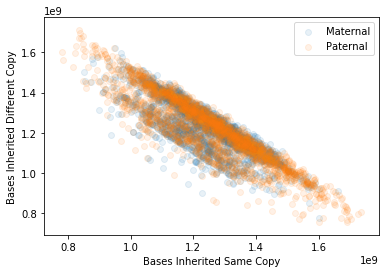

In [40]:
plt.scatter(mat_match, mat_mismatch, alpha=0.1, label='Maternal')
plt.scatter(pat_match, pat_mismatch, alpha=0.1, label='Paternal')

plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

plt.legend()
plt.show()

In [30]:
is_ihart = np.array([sibpair_to_dataset[k] == 'iHART' for k in sibpairs])
is_ssc = np.array([sibpair_to_dataset[k] == 'SSC' for k in sibpairs])

ihart_mat = mat_match[is_ihart]/(mat_match[is_ihart]+mat_mismatch[is_ihart])
ihart_pat = pat_match[is_ihart]/(pat_match[is_ihart]+pat_mismatch[is_ihart])

ssc_mat = mat_match[is_ssc]/(mat_match[is_ssc]+mat_mismatch[is_ssc])
ssc_pat = pat_match[is_ssc]/(pat_match[is_ssc]+pat_mismatch[is_ssc])


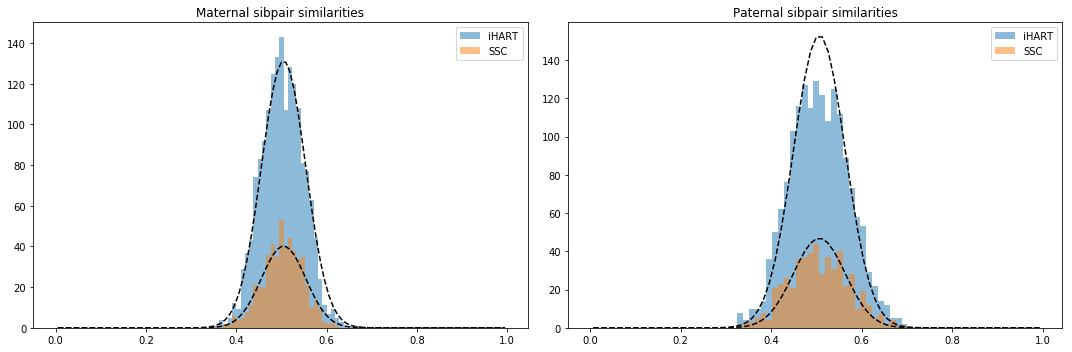

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

In [42]:
# write to file

with open('sibpair_similarity_scores.txt', 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\n')
    for i, sibpair in enumerate(sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], sibpair_to_dataset[sibpair], mat_match[i]/(mat_match[i]+mat_mismatch[i]), pat_match[i]/(pat_match[i]+pat_mismatch[i])))
    